In [1]:
from datasetStuff import expandDataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

In [2]:
def simpleDataRetrieval(data) -> pd.DataFrame:
        X=data["X"]
        XX=pd.DataFrame(X)
        XX.rename(columns={0:"user",1:"item",2:"rating"},inplace=True)

        try:
            y=data["y"]
            yy=pd.DataFrame(y)
            yy.rename(columns={0:"user",1:"label"},inplace=True)
        except:
            yy = None
            
        return XX, yy

In [3]:
data=np.load("first_batch_with_labels_likes.npz")
data2 = np.load("second_batch_with_labels_likes.npz")
df, labels = simpleDataRetrieval(data)
df2, labels2 = simpleDataRetrieval(data2)

In [4]:
df = pd.concat([df,df2]).reset_index(drop=True)
labels = pd.concat([labels,labels2]).reset_index(drop=True)

In [5]:
class stuff:
    def __init__(self):
        return
    
    def doStuff(self, df):
        XX = df.sort_values(by=["item"], ascending=True)
        XX = XX.drop(['user'],axis=1)
        XX = XX.groupby(by='item').aggregate('mean')

        a = []
        for i in df['user'].unique():
            items = list(df.sort_values(by='item')['item'].loc[df['user']==i])
            av_diff=0
            for j in range(0,len(items)-1):
                diff = items[j+1]-items[j]
                av_diff += diff
            av_diff /= len(items)
            item_comp = {'user':i,'items_diff':av_diff}
            a.append(item_comp)
        user_items_diff = pd.DataFrame(a)
        user_items_diff = user_items_diff.sort_values(by='user').reset_index(drop=True)

        f = lambda row: -1 if row < -0.5 else 0
        XX['mode'] = XX['rating'].apply(lambda row: 1 if row > 0.5 else f(row))

        user_item_comp = []
        for i in df['user'].unique():
            user_df = df.loc[df['user']==i]
            item_comp = {'user':i,'modal_ratings':0,'non_modal_ratings':0,'rating_diff':[]}
            for j in user_df['item']:
                user_rating = user_df['rating'].loc[user_df['item']==j].iloc[0]
                item_mode = XX['mode'][j]

                if user_rating == item_mode:
                    item_comp['modal_ratings'] += 1
                else:
                    item_comp['non_modal_ratings'] += 1

                item_comp['rating_diff'].append(abs(item_mode-user_rating))
            user_item_comp.append(item_comp)

        df_new = pd.DataFrame(user_item_comp).sort_values(by='user').reset_index(drop=True)
        df_new['diff_std'] = df_new['rating_diff'].apply(lambda row: np.std(row))
        df_new['diff_mean'] = df_new['rating_diff'].apply(lambda row: np.mean(row))

        mode_ratings_diff = []
        for index,row in df_new.iterrows():
            x = row['modal_ratings']
            y = row['non_modal_ratings']
            diff = min(x,y)/max(x,y)
            mode_ratings_diff.append(diff)
        df_new['mode_ratings_diff'] = mode_ratings_diff
        df_new = df_new.sort_values(by='user').reset_index(drop=True)
        df_new = df_new.join(user_items_diff['items_diff'])

        return df_new


In [6]:
xy = stuff().doStuff(df)
# df_scaled = StandardScaler().fit_transform(xy)
# df_scaled = pd.DataFrame(df_scaled, columns=xy.columns)

In [7]:
xy

,user,modal_ratings,non_modal_ratings,rating_diff,diff_std,diff_mean,mode_ratings_diff,items_diff
0,0,47,70,"[1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 2, ...",0.534718,0.623932,0.671429,8.188034
1,1,12,15,"[1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, ...",0.496904,0.555556,0.800000,4.407407
2,2,61,106,"[2, 1, 1, 0, 0, 1, 1, 1, 1, 2, 0, 1, 1, 0, 2, ...",0.658519,0.760479,0.575472,5.892216
3,3,35,71,"[1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, ...",0.470281,0.669811,0.492958,8.792453
4,4,54,46,"[1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, ...",0.498397,0.460000,0.851852,8.730000
...,...,...,...,...,...,...,...,...
2595,2595,65,55,"[2, 1, 0, 1, 1, 1, 0, 0, 1, 1, 2, 1, 1, 1, 0, ...",0.562670,0.491667,0.846154,6.716667
2596,2596,157,105,"[1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, ...",0.490053,0.400763,0.668790,3.755725
2597,2597,73,112,"[1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, ...",0.517340,0.621622,0.651786,5.318919
2598,2598,190,220,"[1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, ...",0.521546,0.548780,0.863636,2.434146


In [8]:
to_scale = xy.drop(['rating_diff','user'],axis=1)

In [9]:
df_scaled = StandardScaler().fit_transform(to_scale)
df_scaled = pd.DataFrame(df_scaled, columns=to_scale.columns)

In [10]:
fakes = df_scaled.loc[labels['label']==1]
non_fakes = df_scaled.loc[labels['label']==0]

In [11]:
fake_outliers = pd.DataFrame()
non_fake_outliers = pd.DataFrame()

for column in fakes.columns:
    Q1 = fakes[column].quantile(0.25)
    Q3 = fakes[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outlier_rows = fakes.loc[(fakes[column] < lower_bound) | (fakes[column] > upper_bound)]
    fake_outliers = pd.concat([fake_outliers,outlier_rows])

for column in non_fakes.columns:
    Q1 = non_fakes[column].quantile(0.25)
    Q3 = non_fakes[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outlier_rows = non_fakes.loc[(non_fakes[column] < lower_bound) | (non_fakes[column] > upper_bound)]
    non_fake_outliers = pd.concat([non_fake_outliers,outlier_rows])

In [12]:
indexes_to_remove = list(fake_outliers.index)+list(non_fake_outliers.index)

In [13]:
xy = xy.drop(indexes_to_remove)
labels_new = labels.drop(indexes_to_remove)

In [14]:
xy = xy.reset_index()

In [15]:
xy.to_csv("./csv_files/f+s_item_features_no_outliers.csv")

In [17]:
df_scaled = StandardScaler().fit_transform(xy)
df_scaled = pd.DataFrame(df_scaled, columns=xy.columns)

In [18]:
fakes = df_scaled.loc[labels['label']==1]
non_fakes = df_scaled.loc[labels['label']==0]

In [145]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from datasetStuff import assessFeatures

xy_labels = list(labels_new['label'])

assessor = assessFeatures(xy,xy_labels)
X_train, X_val, Y_train, Y_val = train_test_split(xy, xy_labels, test_size=0.2, random_state=42)

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_val = scaler.transform(X_val)

# lr = LogisticRegression(solver="saga", max_iter=1000000, penalty='l2', tol=1e-5)
lr = LogisticRegression()
lr.fit(X_train, Y_train)
y_pred = lr.predict(X_val)

In [285]:
assessor.getScores(Y_val, y_pred)

{'AUC': 0.6584040747028862,
 'f1': 0.42379182156133827,
 'recall': 1.0,
 'precision': 0.2688679245283019}

In [383]:
X_train = StandardScaler().fit_transform(xy)

In [386]:
print("hi")

hi


In [19]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

xy_labels = list(labels_new['label'])

# assessor = assessFeatures(xy,xy_labels)
# X_train, X_val, y_train, y_val = train_test_split(xy, xy_labels, test_size=0.2, random_state=42)
# X_test, X_val, y_test, y_val = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

# input_shape = len(X_train.columns)

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_val = scaler.transform(X_val)

input_shape = len(xy.columns)

X_train = StandardScaler().fit_transform(xy)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(input_shape, activation='relu',input_shape=(input_shape,)),
    # tf.keras.layers.Dropout(0.35),
    tf.keras.layers.Dense(input_shape, activation='sigmoid'),
])

# y_train_categorized, y_val_categorized = to_categorical(y_train, num_classes=2), to_categorical(y_val, num_classes=2)

model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, X_train, epochs=100, batch_size=32)

Epoch 1/100
34/34 [==============================] - 1s 3ms/step - loss: 1.2173
Epoch 2/100
34/34 [==============================] - 0s 3ms/step - loss: 1.1761
Epoch 3/100
34/34 [==============================] - 0s 2ms/step - loss: 1.1362
Epoch 4/100
34/34 [==============================] - 0s 3ms/step - loss: 1.0961
Epoch 5/100
34/34 [==============================] - 0s 3ms/step - loss: 1.0561
Epoch 6/100
34/34 [==============================] - 0s 3ms/step - loss: 1.0162
Epoch 7/100
34/34 [==============================] - 0s 3ms/step - loss: 0.9770
Epoch 8/100
34/34 [==============================] - 0s 3ms/step - loss: 0.9398
Epoch 9/100
34/34 [==============================] - 0s 3ms/step - loss: 0.9048
Epoch 10/100
34/34 [==============================] - 0s 2ms/step - loss: 0.8720
Epoch 11/100
34/34 [==============================] - 0s 3ms/step - loss: 0.8418
Epoch 12/100
34/34 [==============================] - 0s 4ms/step - loss: 0.8133
Epoch 13/100
34/34 [=================

In [128]:
from sklearn.cluster import DBSCAN
import sklearn.cluster as cluster

encoded_data = model.layers[1](X_train)

kmeans = cluster.HDBSCAN()
cluster_labels = kmeans.fit_predict(encoded_data[:,4:6])

In [129]:
np.unique(cluster_labels)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33, 34, 35, 36, 37, 38, 39, 40, 41, 42], dtype=int64)

In [334]:
encoded_data[:,0]

<tf.Tensor: shape=(1058,), dtype=float32, numpy=
array([0.23067157, 0.25945544, 0.0372904 , ..., 0.1735712 , 0.24553259,
       0.85181826], dtype=float32)>

In [ ]:
# y_pred = model.predict(X_test)[:,1]
assessor.getScores(xy_labels, cluster_labels)

{'AUC': 0.3392709441096538,
 'f1': 0.3847328244274809,
 'recall': 1.0,
 'precision': 0.2381852551984877}

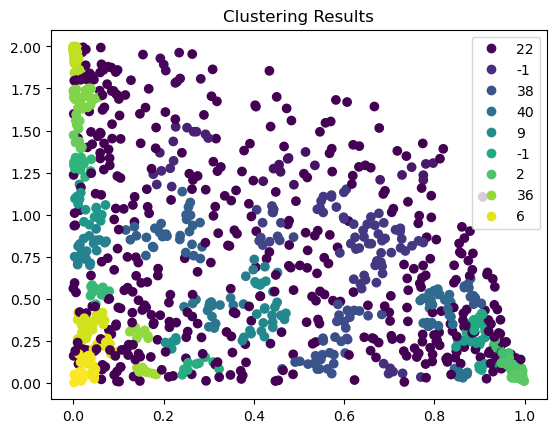

In [139]:
import matplotlib.pyplot as plt

scatter = plt.scatter(encoded_data[:,5], encoded_data[:,4]*2, c=cluster_labels, cmap='viridis')
legend = plt.legend(handles=scatter.legend_elements()[0], labels=list(cluster_labels))
plt.title("Clustering Results")
plt.show()

In [146]:
pred = np.array(encoded_data[:,5] < 0.1).astype(int)
assessor.getScores(xy_labels, pred)

{'AUC': 0.743629130725905,
 'f1': 0.5933682373472948,
 'recall': 0.6746031746031746,
 'precision': 0.5295950155763239}

In [155]:
data=np.load("second_batch_with_labels_likes.npz")
df, labels = simpleDataRetrieval(data)
# df_second = stuff().doStuff(df_second)

In [156]:
XX = df.sort_values(by=["item"], ascending=True)
XX = XX.drop(['user'],axis=1)
XX = XX.groupby(by='item').aggregate('mean')

In [157]:
a = []
for i in df['user'].unique():
    items = list(df.sort_values(by='item')['item'].loc[df['user']==i])
    av_diff=0
    for j in range(0,len(items)-1):
        diff = items[j+1]-items[j]
        av_diff += diff
    av_diff /= len(items)
    item_comp = {'user':i,'items_diff':av_diff}
    a.append(item_comp)
user_items_diff = pd.DataFrame(a)
user_items_diff = user_items_diff.sort_values(by='user').reset_index(drop=True)

In [159]:
f = lambda row: -1 if row < -0.5 else 0
XX['mode'] = XX['rating'].apply(lambda row: 1 if row > 0.5 else f(row))

user_item_comp = []
for i in df['user'].unique():
    user_df = df.loc[df['user']==i]
    item_comp = {'user':i,'modal_ratings':0,'non_modal_ratings':0,'rating_diff':[]}
    for j in user_df['item']:
        user_rating = user_df['rating'].loc[user_df['item']==j].iloc[0]
        item_mode = XX['mode'][j]

        if user_rating == item_mode:
            item_comp['modal_ratings'] += 1
        else:
            item_comp['non_modal_ratings'] += 1

        item_comp['rating_diff'].append(abs(item_mode-user_rating))
    user_item_comp.append(item_comp)

In [174]:
df_new = pd.DataFrame(user_item_comp).sort_values(by='user').reset_index(drop=True)
df_new['diff_std'] = df_new['rating_diff'].apply(lambda row: np.std(row))
df_new['diff_mean'] = df_new['rating_diff'].apply(lambda row: np.mean(row))

mode_ratings_diff = []
for index,row in df_new.iterrows():
    x = row['modal_ratings']
    y = row['non_modal_ratings']
    diff = min(x,y)/max(x,y)
    mode_ratings_diff.append(diff)
df_new['mode_ratings_diff'] = mode_ratings_diff
df_new = df_new.sort_values(by='user').reset_index(drop=True)
df_new = df_new.join(user_items_diff['items_diff'])

In [176]:
xy = df_new.drop(['rating_diff','user'],axis=1)
df_scaled = StandardScaler().fit_transform(xy)
df_scaled = pd.DataFrame(df_scaled, columns=xy.columns)

In [181]:
X_train = StandardScaler().fit_transform(xy)
xy_labels = labels['label']

In [183]:
encoded_data = model.layers[1](X_train)

In [184]:
pred = np.array(encoded_data[:,5] < 0.1).astype(int)
assessor.getScores(xy_labels, pred)

{'AUC': 0.7308333333333333,
 'f1': 0.5735735735735736,
 'recall': 0.6366666666666667,
 'precision': 0.5218579234972678}

In [194]:
tf.saved_model.save(model, "unsupp_classif_73")

INFO:tensorflow:Assets written to: unsupp_classif_73\assets


In [381]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

xy_labels = list(labels_new['label'])

assessor = assessFeatures(xy,xy_labels)
encoded_data = list(encoded_data)
X_train, X_val, y_train, y_val = w[:800], w[800:], xy_labels[:800], xy_labels[:800]
# X_test, X_val, y_test, y_val = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

input_shape = len(X_train[0])

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_val = scaler.transform(X_val)

# input_shape = len(xy.columns)

# X_train = StandardScaler().fit_transform(xy)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='relu',input_shape=(input_shape,)),
    # tf.keras.layers.Dropout(0.35),
    tf.keras.layers.Dense(2, activation='sigmoid'),
])

# y_train_categorized, y_val_categorized = to_categorical(y_train, num_classes=2), to_categorical(y_val, num_classes=2)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val))

ValueError: Failed to find data adapter that can handle input: (<class 'list'> containing values of types {'(<class \'list\'> containing values of types {"<class \'numpy.float32\'>"})'}), (<class 'list'> containing values of types {"<class 'int'>"})

In [366]:
pred_thresh = (np.array(encoded_data[:,2]) > 0.1).astype(int)

In [367]:
assessor.getScores(xy_labels, pred_thresh)

{'AUC': 0.48690870061837804,
 'f1': 0.3847328244274809,
 'recall': 1.0,
 'precision': 0.2381852551984877}

In [ ]:
1.2 , 1.3